In [1]:
# Libraries

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Node Implementation 

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature            
        self.threshold = threshold        
        self.left = left                  
        self.right = right                
        self.value = value                

    def is_leaf_node(self):
        return self.value is not None

In [3]:
# Decision Tree Implementation

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Grow the children recursively
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        n_samples, n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature], threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, y, X_column, threshold):
        # Split data
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Calculate the Gini impurity for the split
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        p_left, p_right = n_left / n, n_right / n

        gain = self._gini(y) - (p_left * self._gini(y[left_idxs]) + p_right * self._gini(y[right_idxs]))
        return gain

    def _split(self, X_column, threshold):
        left_idxs = np.where(X_column <= threshold)[0]
        right_idxs = np.where(X_column > threshold)[0]
        return left_idxs, right_idxs

    def _gini(self, y):
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [4]:
# Random Forest Implementation

class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, sample_size=None, n_features=None, random_state=None):
        """
        Random Forest Classifier.
        
        Parameters:
        - n_trees: int, the number of trees in the forest.
        - max_depth: int or None, the maximum depth of each decision tree.
        - sample_size: int or None, the number of samples to use for each tree.
        - n_features: int or None, the number of features to consider at each split.
        - random_state: int or None, controls randomness for reproducibility.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.n_features = n_features
        self.random_state = random_state
        self.trees = []
    
    def _bootstrap_sample(self, X, y):
        """
        Create a bootstrap sample of the data.
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=self.sample_size or n_samples, replace=True)
        return X[indices], y[indices]
    
    def _random_features(self, X):
        """
        Select a random subset of features for the data.
        """
        n_features = X.shape[1]
        feature_indices = np.random.choice(n_features, size=self.n_features or n_features, replace=False)
        return feature_indices
    
    def fit(self, X, y):
        """
        Train the Random Forest.
        """
        np.random.seed(self.random_state)
        self.trees = []
        for _ in range(self.n_trees):
            # Create a bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)
            
            # Initialize a new decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            
            # Train the decision tree on the bootstrapped data
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        """
        Predict using the Random Forest.
        
        Parameters:
        - X: np.ndarray, feature matrix.
        
        Returns:
        - np.ndarray, predicted labels.
        """
        # Collect predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # Perform majority voting
        majority_votes = [Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(majority_votes)

In [5]:
#Calculate F1 Score

def calculate_f1_score(y_true, y_pred, beta=1):
    """
    Calculate precision, recall, and F-beta score from scratch.
    
    Parameters:
    - y_true: np.ndarray, true labels.
    - y_pred: np.ndarray, predicted labels.
    - beta: float, weight of recall in the F-beta score (default is 1 for F1 score).
    
    Returns:
    - precision: float, the precision score.
    - recall: float, the recall score.
    - f_beta_score: float, the F-beta score.
    """
    # Calculate True Positives, False Positives, and False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F-beta score
    beta_squared = beta ** 2
    f_beta_score = (
        (1 + beta_squared) * precision * recall / (beta_squared * precision + recall)
        if (beta_squared * precision + recall) > 0 else 0
    )
    
    return precision, recall, f_beta_score

In [6]:
# Function for generating synthetic data

def generate_synthetic_data(n_samples=100, n_features=2, noise=0.1):
    """
    Generate synthetic binary classification data for testing a decision tree.
    
    Parameters:
    - n_samples: int, number of samples to generate.
    - n_features: int, number of features (default is 2 for easy visualization).
    - noise: float, level of noise to add to the data.
    
    Returns:
    - X: np.ndarray, feature matrix of shape (n_samples, n_features).
    - y: np.ndarray, labels of shape (n_samples,).
    """
    # Generate random feature data
    X = np.random.rand(n_samples, n_features) * 10  # Scale features between 0 and 10
    
    # Create a linear decision boundary (for simplicity)
    # We'll use the sum of the features to determine the label
    # If sum of features > threshold, assign class 1, else class 0.
    threshold = np.sum(X, axis=1).mean()
    y = (np.sum(X, axis=1) + noise * np.random.randn(n_samples)) > threshold
    
    # Convert boolean labels to integers (0 or 1)
    y = y.astype(int)
    
    return X, y

In [7]:
# Generating Synthetic Data

X, y = generate_synthetic_data(n_samples=1000, n_features=2, noise=0.2)

In [8]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 800 samples
Testing set size: 200 samples


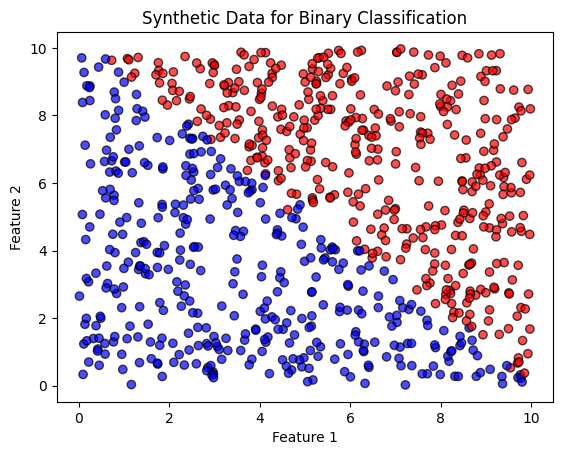

In [9]:
# Visualizing the training Dataset

def plot_synthetic_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Synthetic Data for Binary Classification')
    plt.show()

plot_synthetic_data(X_train, y_train)

In [10]:
# Fit the decision tree on the training set

forest = RandomForest(n_trees=10, max_depth=5, random_state=42)
forest.fit(X_train, y_train)

In [11]:
# Predict on the test set

y_pred = forest.predict(X_test)

In [12]:
# Evaluate accuracy

precision, recall, f1 = calculate_f1_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.97
Recall: 0.97
F1 Score: 0.97


In [13]:
# Visualizing the decision boundary Dataset

def plot_decision_boundary(tree, X, y, resolution=0.02):
    """
    Plot the decision boundary of a decision tree.
    
    Parameters:
    - tree: trained DecisionTree instance.
    - X: np.ndarray, feature matrix (should be 2D).
    - y: np.ndarray, true labels.
    - resolution: float, resolution of the grid for plotting.
    """
    # Define the range of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a meshgrid for plotting
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Predict the class for each point in the meshgrid
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of the Random Forest')
    plt.show()

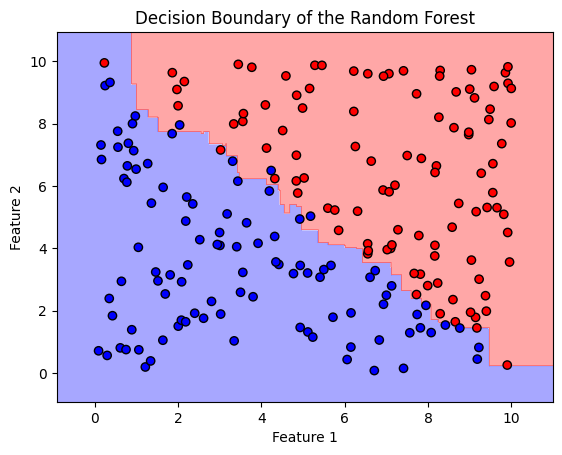

In [14]:
# Plot the decision boundary

plot_decision_boundary(forest, X_test, y_test)